The sample number of Train data:  28709
The sample number of Valid data:  3589
The sample number of Test data:  3589


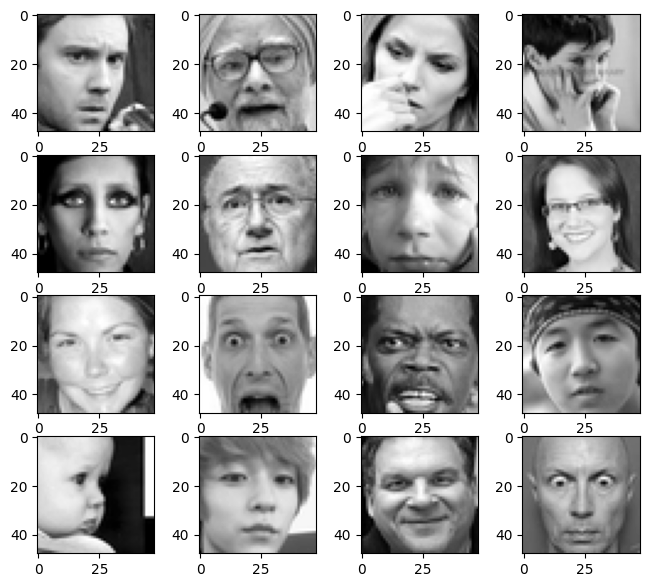

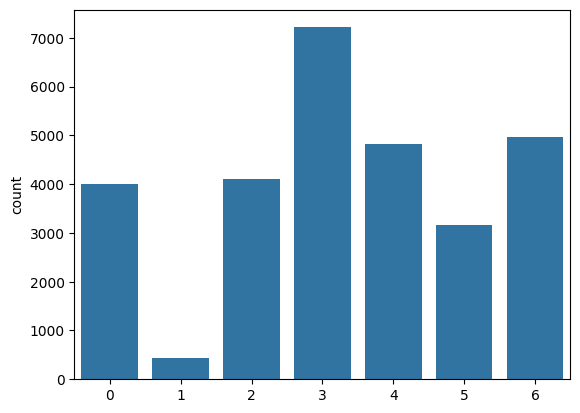

Image batch shape: torch.Size([200, 1, 48, 48])


In [19]:
import torch  # PyTorch库，用于构建和训练深度学习模型
import os  # 操作系统接口
import torch.nn as nn  # PyTorch中的神经网络模块
import torchvision  # PyTorch的计算机视觉工具包
import pandas as pd  # 数据分析库，提供DataFrame等数据结构
import numpy as np  # 科学计算库，支持大型多维数组与矩阵运算
import seaborn as sns  # 统计数据可视化库
import torchvision.transforms as transforms  # 图像变换操作
import matplotlib.pyplot as plt  # 数据可视化库
from torchvision.io import read_image  # 用于读取图像数据
from torch.utils.data import Dataset  # 自定义数据集类的基础类
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # 设置设备，优先使用GPU

# 读取训练、验证、测试数据集的CSV文件
train_d = pd.read_csv("./data/train.csv")
val_d = pd.read_csv("./data/val.csv")
test_d = pd.read_csv("./data/test.csv")
print("The sample number of Train data: ", train_d.shape[0])  # 打印训练集样本数
print("The sample number of Valid data: ", val_d.shape[0])  # 打印验证集样本数
print("The sample number of Test data: ", test_d.shape[0])  # 打印测试集样本数

# 定义自定义数据集类
class FerDataset(Dataset):
    def __init__(self, path_dir, transform=None, target_transform=None):
        MyData = pd.read_csv(path_dir)  # 读取CSV文件
        X, y = Handler(MyData)  # 调用Handler函数处理数据
        self.img_labels = y  # 存储标签
        self.img = X  # 存储图像数据
        self.transform = transform  # 可选图像变换
        self.target_transform = target_transform  # 可选标签变换
    
    def __len__(self):
        return len(self.img_labels)  # 返回数据集长度
    
    def __getitem__(self, idx):
        image = self.img[idx]  # 根据索引获取图像
        label = self.img_labels[idx]  # 获取对应标签
        if self.transform:  # 应用图像变换
            image = self.transform(image)
        if self.target_transform:  # 应用标签变换
            label = self.target_transform(label)
        return image, label  # 返回图像和标签

# 处理训练集数据，将像素值转换为numpy数组并重塑
X_train, y_train = [], [] 
for label, pixel in zip(train_d['emotion'], train_d['pixels']):  # 遍历情绪和像素数据
    pixel_arr = np.array(pixel.split(' '), dtype='float32')  # 分割并转为float32类型
    X_train.append(pixel_arr)
    y_train.append(label)
X_train = np.array(X_train).reshape(-1, 48, 48, 1)  # 重塑为图像格式
y_train = np.array(y_train)

# 同样的处理过程应用于验证集和测试集

# 数据展示部分，使用matplotlib显示前16个训练图像
fig = plt.figure(figsize=(8,7))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    plt.gray()  # 设置灰度模式
    ax.imshow(X_train[i])  # 显示图像
plt.show()

# 使用seaborn绘制训练集中各表情的分布
sns.countplot(x=y_train)
plt.show()

# 定义数据加载器，用于批量读取和处理数据
batch_size = 200
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 获取训练数据加载器中的一个批次数据，展示其形状
images, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)

In [23]:
# 设置训练轮数和学习率
num_epochs = 100
lr = 0.001
# 定义一个卷积神经网络模型类，继承自nn.Module
class ConvNet(nn.Module):
    def __init__(self, num_classes=7):
        super(ConvNet, self).__init__()  # 初始化父类，即nn.Module
        # 第一层卷积块，包含卷积、批归一化、ReLU激活、最大池化
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),  # 卷积层，输入通道1，输出通道16，核大小5x5，步长1，填充2
            nn.BatchNorm2d(16),  # 批归一化，针对16个输出通道
            nn.ReLU(),  # ReLU激活函数
            nn.MaxPool2d(kernel_size=2, stride=2)  # 最大池化，核大小2x2，步长2
        )
        # 第二层卷积块，结构同上，但输入通道变为16，输出通道变为32
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )        
        # 第三层卷积块，结构同上，输入通道变为32，输出通道变为64
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )    
        # 全连接层1，输入维度是根据卷积层输出调整的，经过三次卷积和池化后尺寸变为6x6
        self.fc1 = nn.Linear(64*6*6, 256)    
        # 添加Dropout层，防止过拟合，丢弃比例为0.5
        self.dropout = nn.Dropout(p=0.5)        
        # 输出层，输入维度为前一层的输出维度（256），输出维度为分类数（7）
        self.fc2 = nn.Linear(256, num_classes)   
    def forward(self, x):
        # 前向传播过程
        out = self.layer1(x)  # 第一层卷积块
        out = self.layer2(out)  # 第二层卷积块
        out = self.layer3(out)  # 第三层卷积块
        out = out.view(out.size(0), -1)  # 将特征图展平为一维向量供全连接层使用
        out = self.fc1(out)  # 第一个全连接层
        out = self.dropout(out)  # Dropout层
        out = self.fc2(out)  # 输出层
        return out  # 返回预测结果
# 计算训练数据加载器的长度，即训练批次总数
len(train_loader)

144

Epoch [1/100], Train Loss: 0.0092, Train Accuracy: 0.2398, Val Loss: 0.0088, Val Accuracy: 0.2862
Epoch [2/100], Train Loss: 0.0087, Train Accuracy: 0.3010, Val Loss: 0.0086, Val Accuracy: 0.3165
Epoch [3/100], Train Loss: 0.0085, Train Accuracy: 0.3304, Val Loss: 0.0084, Val Accuracy: 0.3396
Epoch [4/100], Train Loss: 0.0083, Train Accuracy: 0.3573, Val Loss: 0.0082, Val Accuracy: 0.3686
Epoch [5/100], Train Loss: 0.0081, Train Accuracy: 0.3704, Val Loss: 0.0081, Val Accuracy: 0.3823
Epoch [6/100], Train Loss: 0.0080, Train Accuracy: 0.3862, Val Loss: 0.0080, Val Accuracy: 0.3826
Epoch [7/100], Train Loss: 0.0079, Train Accuracy: 0.3958, Val Loss: 0.0079, Val Accuracy: 0.3879
Epoch [8/100], Train Loss: 0.0078, Train Accuracy: 0.4014, Val Loss: 0.0079, Val Accuracy: 0.3954
Epoch [9/100], Train Loss: 0.0078, Train Accuracy: 0.4097, Val Loss: 0.0078, Val Accuracy: 0.3987
Epoch [10/100], Train Loss: 0.0077, Train Accuracy: 0.4150, Val Loss: 0.0078, Val Accuracy: 0.4071
Epoch [11/100], Tra

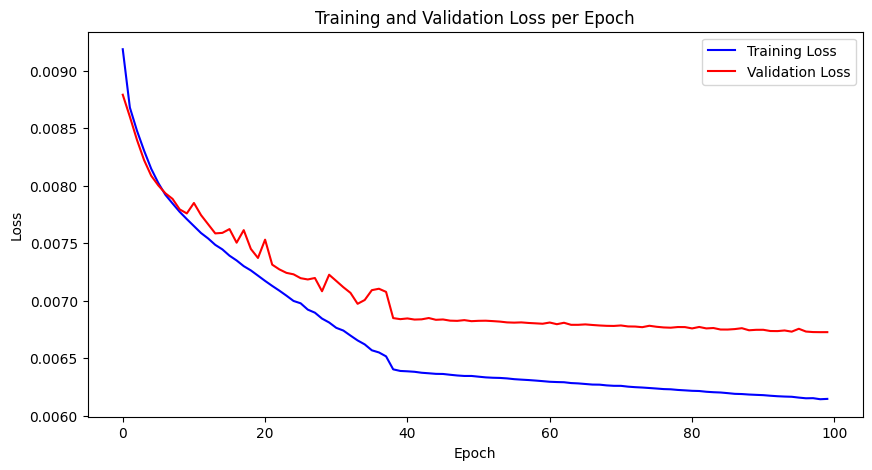

In [24]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 设置设备，优先GPU，否则CPU

# 实例化模型并移动到指定设备上
cnn = ConvNet().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数适用于多分类问题
optimizer = torch.optim.SGD(cnn.parameters(), lr=lr, weight_decay=1e-5)  # SGD随机梯度下降

# 准备记录训练和验证的准确率及损失
train_acc_history = []  
val_acc_history = []  
trainloss_history = []  
validationloss_history = []  

# 学习率调度器，当验证损失停止下降时降低学习率
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

# 初始化最佳验证损失为无穷大，用于早停
best_val_loss = float('inf')
patience_counter = 0
patience = 5  # 设定早停的耐心值，连续多少轮没有改进则停止训练

# 开始训练循环
for epoch in range(num_epochs):
    train_loss = 0  # 初始化训练损失
    validation_loss = 0  # 初始化验证损失
    train_correct = 0  # 初始化训练正确计数
    val_correct = 0  # 初始化验证正确计数
    
    # 训练阶段
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)  # 移动数据至设备
        labels = labels.to(device)
        outputs = cnn(images)  # 前向传播
        train_correct += (outputs.argmax(dim=1) == labels).sum()  # 累加正确预测
        labels = labels.type(torch.LongTensor)  # 确保标签类型正确
        t1 = criterion(outputs, labels)  # 计算损失
        train_loss += t1.item()  # 累加训练损失
        
        optimizer.zero_grad()  # 清零梯度
        t1.backward()  # 反向传播
        optimizer.step()  # 更新权重

    # 验证阶段
    cnn.eval()  # 设置模型为评估模式
    with torch.no_grad():  # 不计算梯度，节省内存
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = cnn(data)
            labels = labels.type(torch.LongTensor)
            t2 = criterion(val_outputs, labels)  # 验证损失
            validation_loss += t2.item()  # 累加验证损失
            _, val_preds = torch.max(val_outputs, 1)  # 获取预测类别
            val_correct += torch.sum(val_preds == labels.data)  # 累加正确预测数量

    # 计算平均损失和准确率
    train_loss /= len(train_loader.dataset)
    train_acc = train_correct.double() / len(train_loader.dataset)
    validation_loss /= len(val_loader.dataset)
    val_acc = val_correct.double() / len(val_loader.dataset)
    
    # 打印每个epoch的结果
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.4f}'
          .format(epoch+1, num_epochs, train_loss, train_acc, validation_loss, val_acc))
    
    # 记录每个epoch的性能指标
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    trainloss_history.append(train_loss)
    validationloss_history.append(validation_loss)
    
    # 调整学习率
    scheduler.step(validation_loss)
    
    # 早停检查
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')  # 达到早停条件，终止训练
            break

# 绘制训练和验证损失曲线
plt.figure(figsize=(10, 5))  # 设置图表大小
plt.plot(trainloss_history, label='Training Loss', color='blue')  # 绘制训练损失曲线
plt.plot(validationloss_history, label='Validation Loss', color='red')  # 绘制验证损失曲线
plt.title('Training and Validation Loss per Epoch')  # 图表标题
plt.xlabel('Epoch')  # x轴标签
plt.ylabel('Loss')  # y轴标签
plt.legend()  # 显示图例
plt.show()  # 显示图表

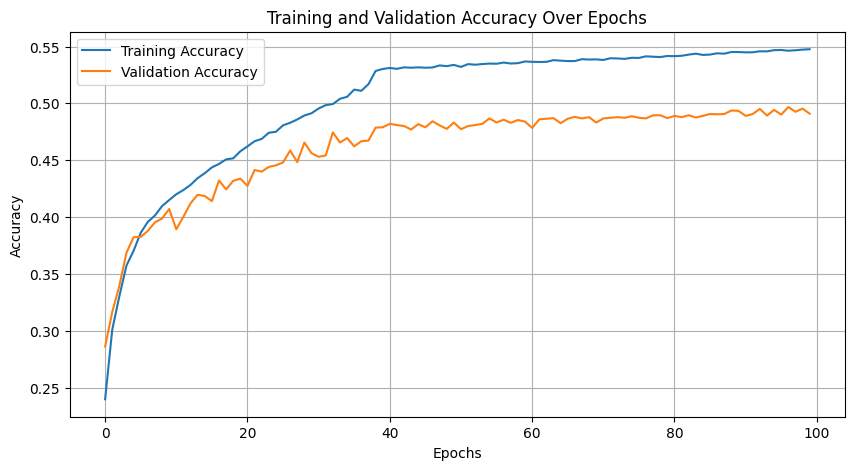

In [26]:
# 使用matplotlib库来绘制训练和验证的准确率随epoch变化的曲线
# 初始化一个新的图表，设置其大小为宽10英寸，高5英寸
plt.figure(figsize=(10,5))
# 绘制训练准确率曲线，使用蓝色表示，标签为'Training Accuracy'
plt.plot(train_acc_history, label='Training Accuracy')
# 绘制验证准确率曲线，使用绿色表示（默认颜色），标签为'Validation Accuracy'
plt.plot(val_acc_history, label='Validation Accuracy')
# 设置图表的标题，说明这是训练和验证准确率随epoch变化的情况
plt.title('Training and Validation Accuracy Over Epochs')
# 设置x轴的标签为'Epochs'，表示横轴代表训练的周期数
plt.xlabel('Epochs')
# 设置y轴的标签为'Accuracy'，表示纵轴代表准确率百分比
plt.ylabel('Accuracy')
# 添加图例，使得训练和验证曲线可以通过图例区分
plt.legend()
# 添加网格线，使图表更易于读取
plt.grid(True)
# 显示图表，完成绘制
plt.show()

In [27]:
# 将模型设置为评估模式，这会关闭所有Dropout和BatchNorm层的训练行为
cnn.eval()  

# 使用上下文管理器with torch.no_grad()来禁用梯度计算，因为测试时我们不需要更新模型参数，这样可以节省内存
with torch.no_grad():  
    # 初始化测试损失和正确预测计数
    test_loss = 0
    test_correct = 0
    
    # 遍历测试数据加载器中的每一个批次
    for data, labels in test_loader:
        # 通过模型得到输出
        outputs = cnn(data)
        
        # 计算批次的损失，注意将labels转换为LongTensor以匹配交叉熵损失函数的要求
        loss = criterion(outputs, labels.type(torch.LongTensor))
        
        # 累加批次损失
        test_loss += loss.item()
        
        # 找出预测概率最大的类别，返回类别索引
        _, preds = torch.max(outputs, 1)
        
        # 计算并累加该批次中预测正确的数量
        test_correct += torch.sum(preds == labels.data)
    
    # 计算平均测试损失
    test_loss /= len(test_dataset)
    
    # 计算整体测试准确率
    test_acc = test_correct.double() / len(test_dataset)
    
    # 打印测试损失和准确率
    print(f'\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# 模型保存路径
model_path = "./model.pth"

# 保存模型的状态字典（权重和偏置）
torch.save(cnn.state_dict(), model_path)
# 提示模型已保存的路径
print(f"Model saved to {model_path}")

# 如果在未来需要加载模型，可以使用以下代码：
# 加载模型结构（假设ConvNet是之前定义的模型类）
# loaded_model = ConvNet()
    
# 加载之前保存的模型状态字典
# loaded_model.load_state_dict(torch.load(model_path))
    
# 确保加载后的模型也是评估模式
# loaded_model.eval()


Test Loss: 0.0068, Test Accuracy: 0.4870
Model saved to ./model.pth
